In [25]:
import gpytorch
import time
import torch
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import FloatSlider, interact
from scipy.optimize import minimize
from types import SimpleNamespace as Namespace
from scipy.stats import multivariate_normal
import warnings

In [26]:
import gp
import utils

In [27]:
%config InlineBackend.figure_format='retina'
%matplotlib inline
%load_ext autoreload
%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Dummy data

In [28]:
torch.manual_seed(123)
train_x = torch.linspace(0, 1, 100)
# sin(2*pi*x) with Gaussian noise
train_y = torch.sin(train_x * (2 * np.pi)) + torch.randn(train_x.size()) * np.sqrt(0.04)
test_x = torch.linspace(0, 1, 51)

# Dummy generative model

In [38]:
a = 2
a*0.01 == a*1e-2

True

In [39]:
def base_activity(x, add_noise=True,
      a=-1.62*1e-2,
      b=0.37,
      c=0.84, 
      d=-1.00, 
      e=0.01):
    
    y = e*(a*x**4 + b*x**3 + c*x**2 + d*x)
    if add_noise:
        y += torch.randn(x.size()) * 0.2
        
    return y

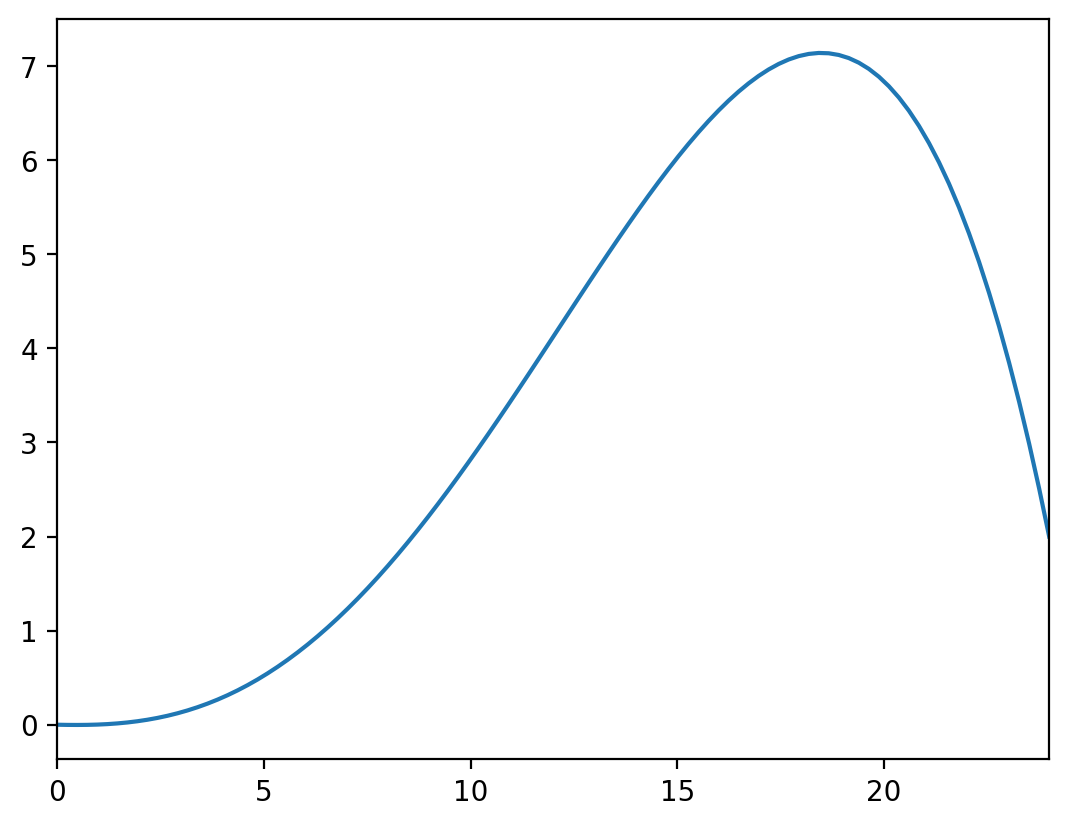

In [44]:
x =  np.linspace(0, 24, 100)
y = base_activity(x, add_noise=False)

fig, ax = plt.subplots()
ax.plot(x, y);
ax.set_xlim(0, 24);

In [52]:
x =  torch.arange(0.1, 24.1, 0.1)
total_step = f(x).sum()
total_step

tensor(851.4356)

In [ ]:
def reward_effect(rewards):
    

Effect of reward on behavior:
- quantity
- distance since last reward
- expectation of a reward coming soon 
- trade-off between predictability and surprise 


---

---

In [30]:
class GP(gpytorch.models.ExactGP):
    def __init__(self):
        super(GP, self).__init__(
            torch.empty(0), 
            torch.empty(0), 
            gpytorch.likelihoods.GaussianLikelihood())
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
            
    def predict(self, test_x):
        
        # Get into evaluation (predictive posterior) mode
        self.eval()

        # Make predictions by feeding model through likelihood
        with torch.no_grad(), gpytorch.settings.fast_pred_var():
            output = self(test_x)
            observed_pred = self.likelihood(output)
        return observed_pred
    
    @property
    def gp_param(self):
        return torch.cat([param.data.flatten() for param in self.parameters()])
        
    def fit(self, train_x, train_y, learning_rate=0.1, n_epochs=25):
    
        self.set_train_data(inputs=train_x, targets=train_y, strict=False)
        
        # Find optimal model hyperparameters
        self.train()

        # Use the adam optimizer
        # Includes GaussianLikelihood parameters
        optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)

        # "Loss" for GPs - the marginal log likelihood
        mll = gpytorch.mlls.ExactMarginalLogLikelihood(self.likelihood, self)
        
        previous_gp_param = self.gp_param.clone()

        for i in range(n_epochs):
            # Zero gradients from previous iteration
            optimizer.zero_grad()
            # Output from model
            output = self(train_x)
            # Calc loss and backprop gradients
            loss = -mll(output, train_y)
            loss.backward()

            optimizer.step()
            
            if torch.allclose(self.gp_param, previous_gp_param, rtol=1e-05, atol=1e-04):
                print(f"Early stop at iter {i}")
                break
            previous_gp_param = self.gp_param.clone()

Early stop at iter 229


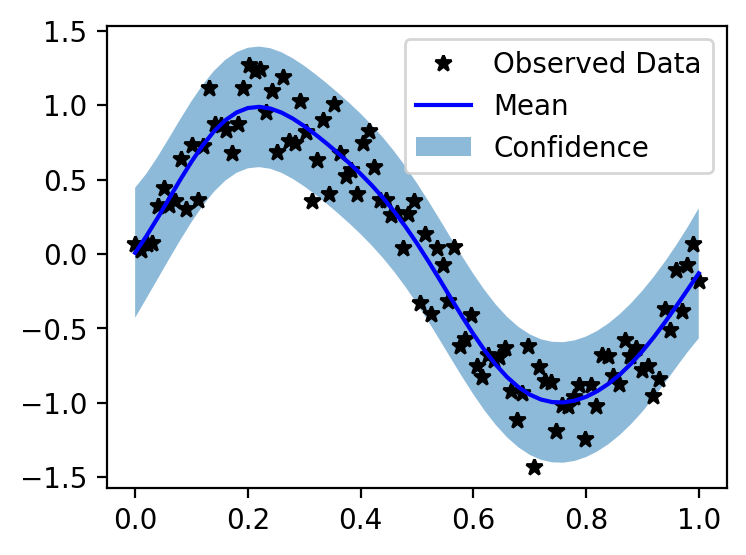

In [31]:
gp = GP()
gp.fit(train_x, train_y, n_epochs=1000)
pred = gp.predict(test_x)
utils.plot.gp_plot(pred, train_x=train_x, train_y=train_y, test_x=test_x);

In [35]:
# Get into evaluation (predictive posterior) mode
gp.eval()

# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    output = gp(test_x)
    pred = gp.likelihood(output)
    
avg = pred.mean

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    ys = gp(test_x).sample(torch.Size((10, )))

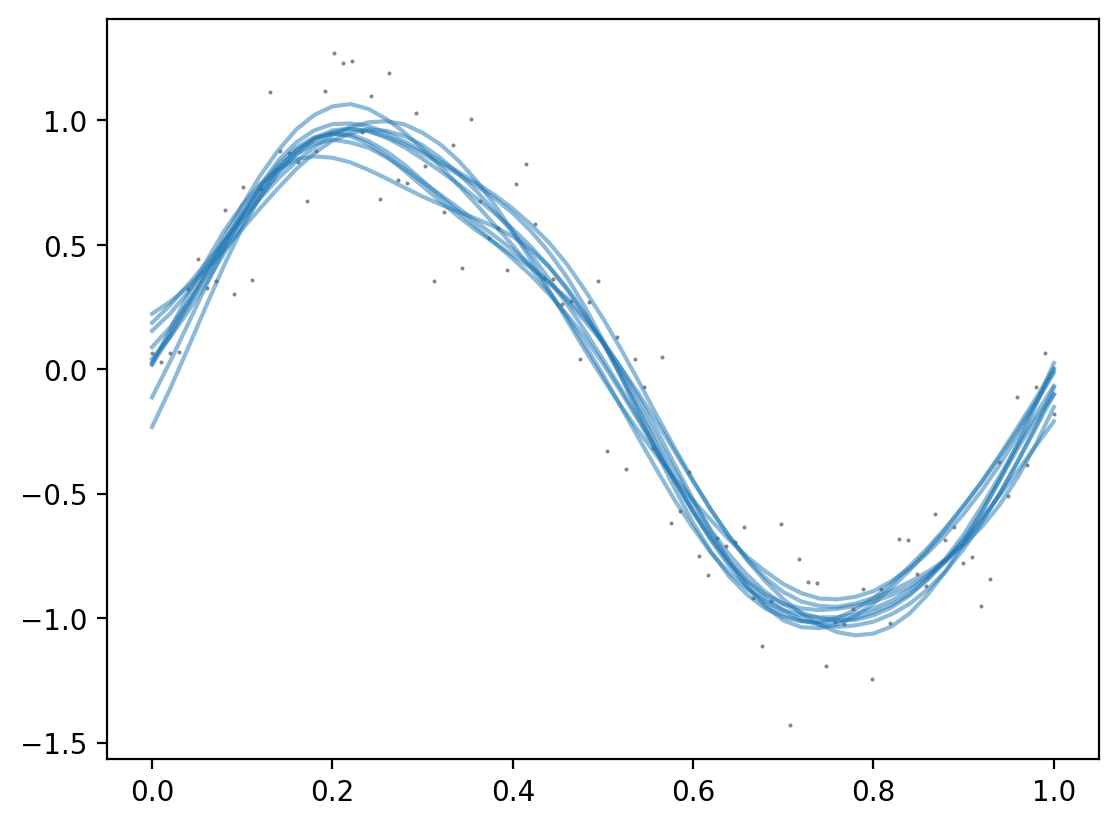

In [36]:
fig, ax = plt.subplots()
ax.scatter(train_x.numpy(), train_y.numpy(), color="black", alpha=0.5, s=0.2)
for y in ys:
    ax.plot(test_x.numpy(), y.numpy(), color="C0", alpha=0.5)